Mean Load: 50 ; Variance Load: 10


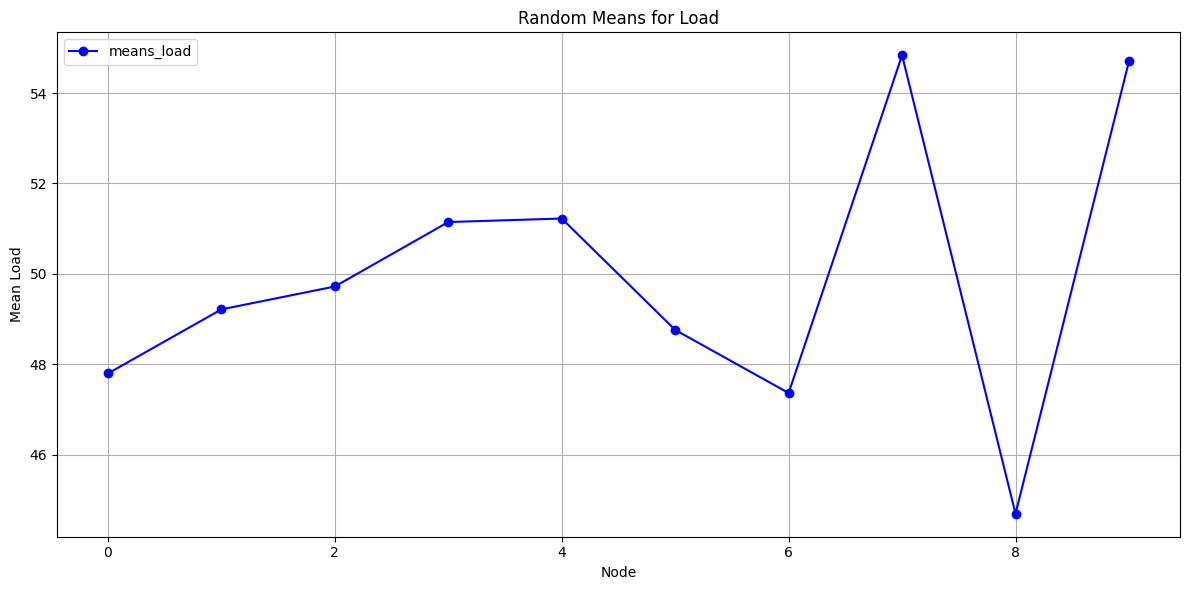

[47.79689888 49.21399941 49.72059105 51.1464616  51.22430927 48.76016644
 47.36376292 54.83645052 44.6915097  54.70000672]


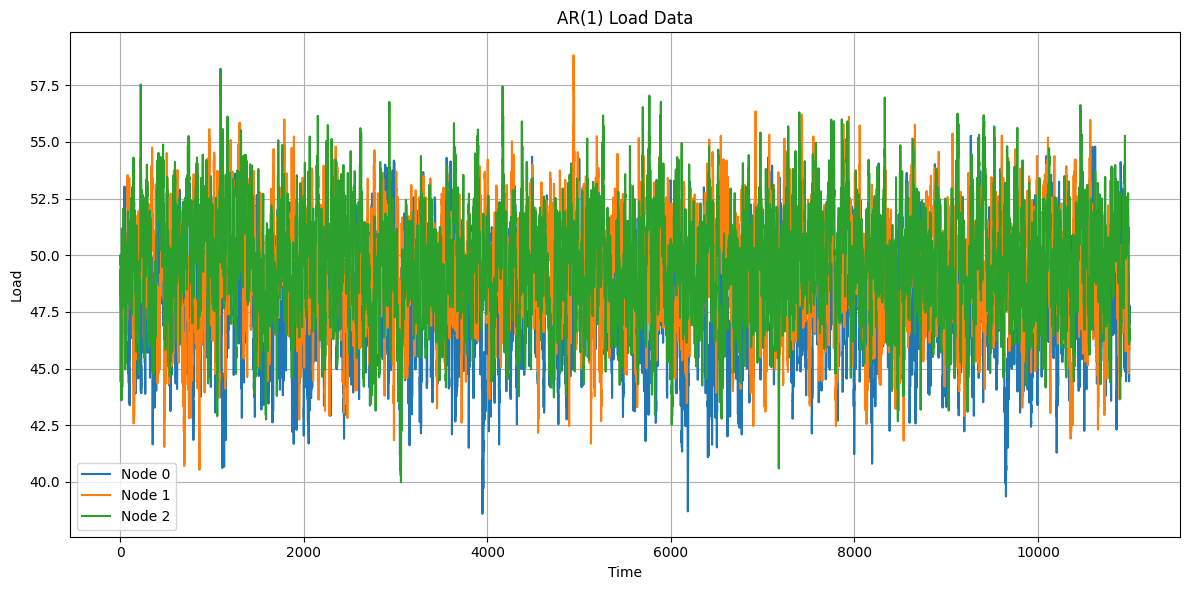

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import networkx as nx


# Function to generate random means
def generate_means(N, mean_load, var_load):
    print('Mean Load:', mean_load, '; Variance Load:', var_load)
    means_load = np.random.normal(loc=mean_load, scale=np.sqrt(var_load), size=N)

    # Plotting means_load
    plt.figure(figsize=(12, 6))
    plt.plot(means_load, marker='o', linestyle='-', color='b', label='means_load')
    plt.title('Random Means for Load')
    plt.xlabel('Node')
    plt.ylabel('Mean Load')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

    return means_load


# Function to generate IID data
def generate_iid_data(N, T, means_load):
    loads = np.array([np.random.normal(loc=means_load[i], scale=1, size=T) for i in range(N)])

    return loads, np.mean(loads, axis=1)


# Function to generate AR(1) data
def generate_ar1_data(N, T, means_load, theta):
    loads = np.zeros((N, T))

    def generate_ar1(theta, T, mean_node):
        ar1 = np.zeros(T)
        ar1[0] = mean_node
        for t in range(1, T):
            ar1[t] = theta * ar1[t - 1] + (1 - theta) * mean_node + np.random.normal(0, 1)
        return ar1

    for i in range(N):
        loads[i] = generate_ar1(theta, T, means_load[i])

    return loads, np.mean(loads, axis=1)


# 绘制指定范围内的AR(1)数据
def plot_ar1_data(load_data, start, end):
    N, T = load_data.shape
    time_steps = np.arange(start, end)

    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(time_steps, load_data[i, start:end], label=f'Node {i}')
    plt.title('AR(1) Load Data')
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()


N = 10
T_train = 10000
T_test = 1000
T = T_train + T_test
mean_load = 50
var_load = 10

means_load = generate_means(N, mean_load, var_load)
print(means_load)

# Generate IID data
load_iid, load_iid_means = generate_iid_data(N, T, means_load)

# Generate AR(1) data
theta = 0.9
load_ar1, load_ar1_means = generate_ar1_data(N, T, means_load, theta)
# Plotting AR(1) data
plot_ar1_data(load_ar1[:3], 0, T)

In [ ]:
# 导入csv数据
data = pd.read_csv('load_ar1_data.csv')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class GNNTimeSeriesPredictor:
    def __init__(self, data, T_train, batch_size=32, seq_length=20, input_size=10, output_size=10, learning_rate=0.001):
        self.data = data
        self.T_train = T_train
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Prepare the dataset
        self.train_data = torch.tensor(data[:, :T_train], dtype=torch.float32)
        self.test_data = torch.tensor(data[:, T_train:], dtype=torch.float32)

        sequences, targets = self.create_sequences(self.train_data, self.seq_length, self.T_train)
        self.train_dataset = TensorDataset(sequences, targets)
        self.dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

        # Create the model
        self.model = GNNModel(in_channels=self.input_size, out_channels=self.output_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

        # Assume a fully connected graph structure
        self.edge_index = torch.tensor(np.array([(i, j) for i in range(self.input_size) for j in range(self.input_size)]).T, dtype=torch.long)

    def create_sequences(self, data, seq_length, T_train):
        sequences = []
        targets = []
        for i in range(T_train - seq_length):
            seq = data[:, i: i + seq_length].T
            target = data[:, i + seq_length]
            sequences.append(seq)
            targets.append(target)
        return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(np.array(targets), dtype=torch.float32)

    def train(self, num_epochs=100):
        self.model.train()
        for epoch in tqdm(range(num_epochs), desc="Training"):
            for inputs, targets in self.dataloader:
                outputs = self.model(inputs, self.edge_index)
                loss = self.criterion(outputs, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

    def test(self, T_test):
        total_loss = 0
        predictions = []
        true_values = []
        x_test = self.train_data[:, -self.seq_length:].T.unsqueeze(0)

        self.model.train()
        for i in range(T_test):
            pred = self.model(x_test, self.edge_index)
            real_value = self.test_data[:, i]

            predictions.append(pred.squeeze(0).detach().cpu().numpy())
            true_values.append(real_value.detach().cpu().numpy())

            loss = self.criterion(pred.squeeze(0), real_value)
            total_loss += loss.item()
            print(f'Step [{i + 1}/{T_test}], Loss: {loss.item():.4f}')

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            x_test = torch.cat((x_test[:, 1:, :], real_value.unsqueeze(0).unsqueeze(0)), dim=1)

        avg_loss = total_loss / T_test
        print(f'Average Loss over {T_test} steps: {avg_loss:.4f}')

        return np.array(predictions), np.array(true_values)

    def plot_predictions(self, predictions, true_values):
        plt.figure(figsize=(12, 6))
        plt.plot(predictions[:, 0], label='Predicted')
        plt.plot(true_values[:, 0], label='True')
        plt.xlabel('Time Steps')
        plt.ylabel('Load Value')
        plt.title('Predicted vs True Load Values for Node 1')
        plt.legend()
        plt.show()


class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.rnn = torch.nn.GRU(out_channels, out_channels, batch_first=True)
        self.fc = torch.nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        batch_size, seq_len, num_nodes = x.size()

        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)

        out, _ = self.rnn(x)

        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# predictor = GNNTimeSeriesPredictor(data=load_ar1, T_train=1000)
# predictor.train(num_epochs=100)
# predictions, true_values = predictor.test(T_test=1000)
# predictor.plot_predictions(predictions, true_values)


Training:  10%|█         | 10/100 [00:11<01:38,  1.09s/it]

Epoch [10/100], Loss: 886.5583


Training:  20%|██        | 20/100 [00:32<03:03,  2.29s/it]

Epoch [20/100], Loss: 172.5035


Training:  30%|███       | 30/100 [00:54<02:33,  2.20s/it]

Epoch [30/100], Loss: 8.4264


Training:  40%|████      | 40/100 [01:15<01:55,  1.93s/it]

Epoch [40/100], Loss: 5.2023


Training:  50%|█████     | 50/100 [01:39<02:02,  2.46s/it]

Epoch [50/100], Loss: 3.9750


Training:  60%|██████    | 60/100 [02:03<01:39,  2.49s/it]

Epoch [60/100], Loss: 4.1519


Training:  70%|███████   | 70/100 [02:26<01:07,  2.25s/it]

Epoch [70/100], Loss: 4.6380


Training:  80%|████████  | 80/100 [02:48<00:44,  2.22s/it]

Epoch [80/100], Loss: 4.5518


Training:  90%|█████████ | 90/100 [03:09<00:22,  2.24s/it]

Epoch [90/100], Loss: 4.7870


Training: 100%|██████████| 100/100 [03:36<00:00,  2.17s/it]

Epoch [100/100], Loss: 4.7969
Step [1/1000], Loss: 5.6826
Step [2/1000], Loss: 4.0390
Step [3/1000], Loss: 5.0291
Step [4/1000], Loss: 4.8566
Step [5/1000], Loss: 4.4255
Step [6/1000], Loss: 3.7674
Step [7/1000], Loss: 5.3032
Step [8/1000], Loss: 3.5895
Step [9/1000], Loss: 5.2948
Step [10/1000], Loss: 5.2301
Step [11/1000], Loss: 5.2830
Step [12/1000], Loss: 4.6011
Step [13/1000], Loss: 4.3421
Step [14/1000], Loss: 3.8492
Step [15/1000], Loss: 2.2391
Step [16/1000], Loss: 2.9405
Step [17/1000], Loss: 4.3830
Step [18/1000], Loss: 5.6441
Step [19/1000], Loss: 3.0744
Step [20/1000], Loss: 2.7589
Step [21/1000], Loss: 2.5065
Step [22/1000], Loss: 1.8449
Step [23/1000], Loss: 2.0448
Step [24/1000], Loss: 3.1245
Step [25/1000], Loss: 4.5021
Step [26/1000], Loss: 3.0058
Step [27/1000], Loss: 2.1494
Step [28/1000], Loss: 3.2148
Step [29/1000], Loss: 2.3892
Step [30/1000], Loss: 1.9128
Step [31/1000], Loss: 3.7380


Step [32/1000], Loss: 1.8709
Step [33/1000], Loss: 2.1641
Step [34/1000], Loss: 2.2660
Step [35/1000], Loss: 2.5834
Step [36/1000], Loss: 2.8236
Step [37/1000], Loss: 2.4845
Step [38/1000], Loss: 1.3896
Step [39/1000], Loss: 1.6771
Step [40/1000], Loss: 2.1595
Step [41/1000], Loss: 1.3476
Step [42/1000], Loss: 2.8377
Step [43/1000], Loss: 1.5347
Step [44/1000], Loss: 1.5298
Step [45/1000], Loss: 2.1304
Step [46/1000], Loss: 1.7072
Step [47/1000], Loss: 3.2210
Step [48/1000], Loss: 2.2733
Step [49/1000], Loss: 2.2746
Step [50/1000], Loss: 2.7876
Step [51/1000], Loss: 3.4582
Step [52/1000], Loss: 3.1024
Step [53/1000], Loss: 1.9469
Step [54/1000], Loss: 2.2235
Step [55/1000], Loss: 3.1377
Step [56/1000], Loss: 4.6449
Step [57/1000], Loss: 4.2568
Step [58/1000], Loss: 2.1183
Step [59/1000], Loss: 3.1917
Step [60/1000], Loss: 2.8193
Step [61/1000], Loss: 3.5037
Step [62/1000], Loss: 3.2550
Step [63/1000], Loss: 4.2438
Step [64/1000], Loss: 1.4444
Step [65/1000], Loss: 2.2869
Step [66/1000]

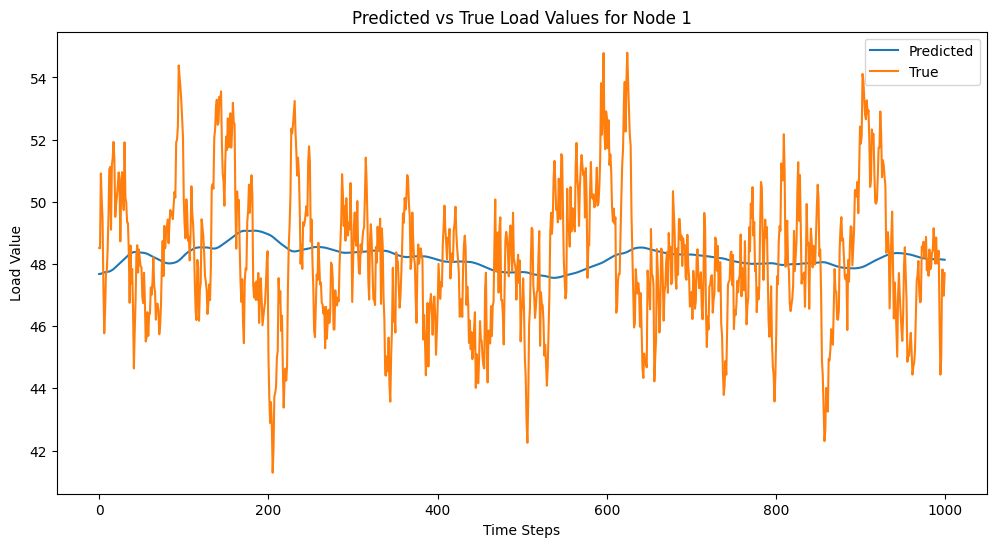

In [5]:
# 假设你已经准备好了 load_ar1, T_train, 和 T_test
data = load_ar1
T_train = 10000
T_test = 1000

# 1. 实例化预测器
predictor = GNNTimeSeriesPredictor(
    data=data,
    T_train=T_train,
    batch_size=64,
    seq_length=20,
    input_size=10,
    output_size=10,
    learning_rate=0.001
)

# 2. 训练模型
predictor.train(num_epochs=100)

# 3. 测试模型
predictions, true_values = predictor.test(T_test=T_test)

# 4. 绘制结果
predictor.plot_predictions(predictions, true_values)
